In [11]:
import pandas as pd

C:\Users\pkastner\AppData\Local\Temp\ipykernel_64092\224983077.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_place(place, tags={'building': True})
C:\Users\pkastner\AppData\Local\Temp\ipykernel_64092\224983077.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(["Streets", "Campus Boundary", "Buildings"], loc="upper right")


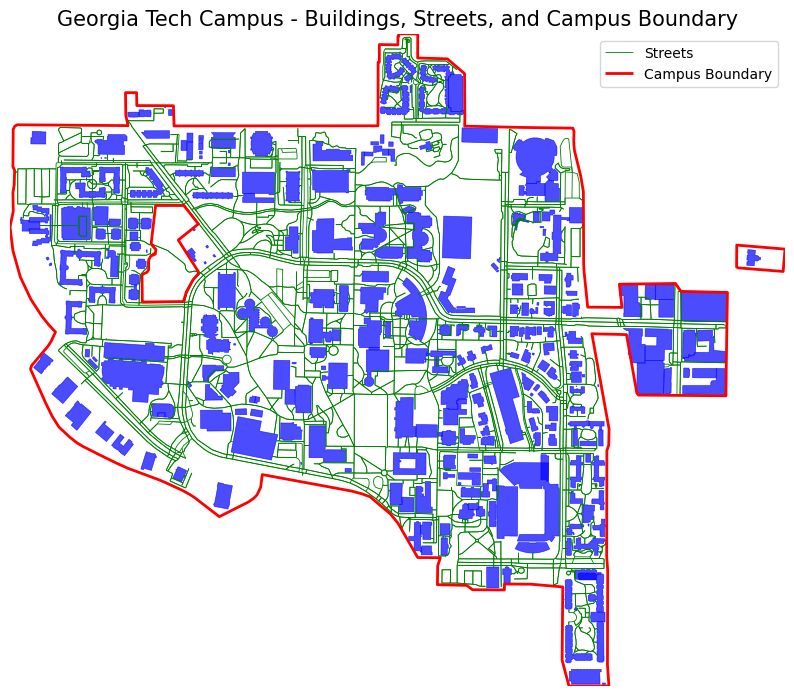

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the location - Georgia Tech, Atlanta, GA
place = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download building footprints
buildings = ox.geometries_from_place(place, tags={'building': True})

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(place, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(place)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds

# Plot everything together
fig, ax = plt.subplots(figsize=(10, 10))

# Plot buildings
buildings.plot(ax=ax, color="blue", edgecolor="blue", linewidth=0.5, alpha=0.7, label="Buildings")

# Plot streets
ox.plot_graph(streets, ax=ax, show=False, close=False, edge_color="green", edge_linewidth=0.6, node_size=0)

# Plot the campus boundary
campus_boundary.boundary.plot(ax=ax, color="red", linewidth=2, label="Campus Boundary")

# Set axis limits to the full extent of the campus boundary
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


# Customize the plot
ax.set_title("Georgia Tech Campus - Buildings, Streets, and Campus Boundary", fontsize=15)
ax.axis("off")
plt.legend(["Streets", "Campus Boundary", "Buildings"], loc="upper right")
plt.show()


In [26]:
"""
Grid Generator - Optimized for Large Areas
Includes density controls and performance optimizations
Modified to show building distances in popups
"""

import osmnx as ox
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import folium
from tqdm import tqdm

def get_utm_crs(lat: float, lon: float) -> str:
    """Calculate UTM zone for given coordinates."""
    zone_number = int((lon + 180) / 6) + 1
    hemisphere = 'north' if lat >= 0 else 'south'
    epsg = f"326{zone_number:02d}" if hemisphere == 'north' else f"327{zone_number:02d}"
    return f"EPSG:{epsg}"

class OptimizedGridGenerator:
    def __init__(self, 
                 bbox, 
                 spacing_meters=100, 
                 network_type="all_private",
                 max_points=5000):
        """Initialize optimized grid generator."""
        self.bbox = bbox
        self.max_points = max_points
        
        # Create initial GeoDataFrame from bbox
        self.area = gpd.GeoDataFrame(
            geometry=[box(*bbox)],
            crs="EPSG:4326"
        )
        
        # Get UTM zone
        center_lat = (bbox[1] + bbox[3]) / 2
        center_lon = (bbox[0] + bbox[2]) / 2
        self.utm_crs = get_utm_crs(center_lat, center_lon)
        
        print(f"Using UTM zone: {self.utm_crs}")
        
        # Project area to UTM
        self.area_projected = self.area.to_crs(self.utm_crs)
        
        # Calculate appropriate spacing based on area and max points
        self._adjust_spacing(spacing_meters)
        
        # Download street network (optional - can be done later)
        self.network_type = network_type
        self.graph = None
        
        # Generate grid points
        self._generate_points()

    def _adjust_spacing(self, requested_spacing):
        """Adjust spacing to respect max_points limit."""
        bounds = self.area_projected.total_bounds
        area_width = bounds[2] - bounds[0]
        area_height = bounds[3] - bounds[1]
        
        n_cols = int(area_width / requested_spacing) + 1
        n_rows = int(area_height / requested_spacing) + 1
        total_points = n_cols * n_rows
        
        if total_points > self.max_points:
            area = area_width * area_height
            point_density = self.max_points / area
            adjusted_spacing = np.sqrt(1 / point_density)
            print(f"Adjusting spacing from {requested_spacing}m to {adjusted_spacing:.1f}m to limit points")
            self.spacing_meters = adjusted_spacing
        else:
            self.spacing_meters = requested_spacing

    def _generate_points(self):
        """Generate grid points with optimization."""
        bounds = self.area_projected.total_bounds
        
        x = np.arange(bounds[0], bounds[2], self.spacing_meters)
        y = np.arange(bounds[1], bounds[3], self.spacing_meters)
        xx, yy = np.meshgrid(x, y)
        
        points = gpd.GeoDataFrame(
            geometry=[Point(x, y) for x, y in zip(xx.flatten(), yy.flatten())],
            crs=self.area_projected.crs
        )
        
        self.points_gdf = gpd.clip(points, self.area_projected)
        self.points_gdf = self.points_gdf.to_crs("EPSG:4326")
        
        print(f"Generated {len(self.points_gdf)} points with {self.spacing_meters:.1f}m spacing")

    def load_network(self, force_reload=False):
        """Load street network on demand."""
        if self.graph is None or force_reload:
            print("Downloading street network...")
            self.graph = ox.graph_from_bbox(
                north=self.bbox[3], south=self.bbox[1],
                east=self.bbox[2], west=self.bbox[0],
                network_type=self.network_type
            )
            self.graph_projected = ox.project_graph(self.graph, to_crs=self.utm_crs)

    def get_nearest_nodes(self, batch_size=100):
        """Find nearest network nodes in batches."""
        if self.graph is None:
            self.load_network()
        
        print("Finding nearest nodes in batches...")
        nearest_nodes = []
        distances = []
        
        for i in tqdm(range(0, len(self.points_gdf), batch_size)):
            batch = self.points_gdf.iloc[i:i+batch_size]
            nearest = ox.nearest_nodes(
                self.graph,
                X=batch.geometry.x.tolist(),
                Y=batch.geometry.y.tolist(),
                return_dist=True
            )
            nearest_nodes.extend(nearest[0])
            distances.extend(nearest[1])
        
        self.points_gdf['nearest_node'] = nearest_nodes
        self.points_gdf['distance_to_node'] = distances
        return self.points_gdf

    def plot_with_network(self, show_network=True, max_points_to_plot=1000):
        """Create interactive map with enhanced popups including distance information."""
        if show_network and self.graph is None:
            self.load_network()
            
        # Calculate center
        center_lat = (self.bbox[1] + self.bbox[3]) / 2
        center_lon = (self.bbox[0] + self.bbox[2]) / 2
        
        # Create map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=15
        )
        
        # Add boundary
        folium.GeoJson(
            self.area,
            style_function=lambda x: {
                'color': 'red',
                'weight': 2,
                'fillOpacity': 0
            }
        ).add_to(m)
        
        # Add street network
        if show_network and self.graph is not None:
            ox.plot_graph_folium(
                self.graph,
                graph_map=m,
                weight=1,
                color='gray'
            )
        
        # Sample points if there are too many
        points_to_plot = self.points_gdf
        if len(self.points_gdf) > max_points_to_plot:
            print(f"Sampling {max_points_to_plot} points for visualization")
            points_to_plot = points_to_plot.sample(max_points_to_plot)
        
        # Define color function based on building distance
        def get_point_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'  # No building distance data
            elif distance < 10:
                return 'red'
            elif distance < 25:
                return 'orange'
            elif distance < 50:
                return 'yellow'
            else:
                return 'blue'
        
        # Add points with enhanced popups
        for idx, point in points_to_plot.iterrows():
            # Create popup content with distance information
            popup_content = [
                f'<strong>Point ID:</strong> {idx}',
                f'<strong>Coordinates:</strong>',
                f'Lat: {point.geometry.y:.6f}',
                f'Lon: {point.geometry.x:.6f}'
            ]
            
            # Add building distance if available
            building_distance = point.get('distance_to_building', None)
            if building_distance is not None and not np.isnan(building_distance):
                popup_content.append(
                    f'<strong>Distance to nearest building:</strong> {building_distance:.1f}m'
                )
                point_color = get_point_color(building_distance)
            else:
                popup_content.append('<strong>Distance to building:</strong> Not calculated')
                point_color = 'gray'
            
            # Add street distance if available
            street_distance = point.get('distance_to_node', None)
            if street_distance is not None and not np.isnan(street_distance):
                popup_content.append(
                    f'<strong>Distance to nearest street:</strong> {street_distance:.1f}m'
                )
            
            # Create popup with HTML formatting
            popup_html = '<br>'.join(popup_content)
            
            # Create tooltip with distance info
            if building_distance is not None and not np.isnan(building_distance):
                tooltip = f'Building: {building_distance:.1f}m'
            else:
                tooltip = 'Click for details'
            
            # Add circle marker
            folium.CircleMarker(
                location=[point.geometry.y, point.geometry.x],
                radius=3,
                color=point_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
        
        # Add a legend
        legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; right: 50px; width: 170px;
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white;
                         padding: 10px;
                         border-radius: 5px;
                         ">
             <p style="margin-bottom: 5px"><strong>Distance to Building</strong></p>
             <p style="margin: 2px;"><span style="color: red;">●</span> < 10m</p>
             <p style="margin: 2px;"><span style="color: orange;">●</span> < 25m</p>
             <p style="margin: 2px;"><span style="color: yellow;">●</span> < 50m</p>
             <p style="margin: 2px;"><span style="color: blue;">●</span> ≥ 50m</p>
             <p style="margin: 2px;"><span style="color: gray;">●</span> No data</p>
             </div>
             '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        return m
    
    def calculate_building_distances(self, buildings_gdf):
        """Calculate distance from each grid point to the nearest building."""
        print("Calculating distances to nearest buildings...")
        
        # Project buildings to same UTM CRS as our grid
        buildings_projected = buildings_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of buildings for faster computation
        from shapely.ops import unary_union
        buildings_union = unary_union(buildings_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(buildings_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_building'] = distances
        print(f"Calculated distances for {len(self.points_gdf)} points")

    def calculate_park_distances(self, parks_gdf):
        """Calculate distance from each grid point to the nearest park."""
        print("Calculating distances to nearest parks...")
        
        # Project parks to same UTM CRS as our grid
        parks_projected = parks_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of parks for faster computation
        from shapely.ops import unary_union
        parks_union = unary_union(parks_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(parks_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_park'] = distances
        print(f"Calculated park distances for {len(self.points_gdf)} points")

    def plot_with_network(self, show_network=True, max_points_to_plot=1000):
        """Create interactive map with enhanced popups including distance information."""
        if show_network and self.graph is None:
            self.load_network()
            
        # Calculate center
        center_lat = (self.bbox[1] + self.bbox[3]) / 2
        center_lon = (self.bbox[0] + self.bbox[2]) / 2
        
        # Create map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=15
        )
        
        # Add boundary
        folium.GeoJson(
            self.area,
            style_function=lambda x: {
                'color': 'red',
                'weight': 2,
                'fillOpacity': 0
            }
        ).add_to(m)
        
        # Add street network
        if show_network and self.graph is not None:
            ox.plot_graph_folium(
                self.graph,
                graph_map=m,
                weight=1,
                color='gray'
            )
        
        # Sample points if there are too many
        points_to_plot = self.points_gdf
        if len(self.points_gdf) > max_points_to_plot:
            print(f"Sampling {max_points_to_plot} points for visualization")
            points_to_plot = points_to_plot.sample(max_points_to_plot)
        
        # Define color function based on building and park distances
        def get_building_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 10:
                return 'red'
            elif distance < 25:
                return 'orange'
            elif distance < 50:
                return 'yellow'
            else:
                return 'blue'

        def get_park_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of a park
                return 'darkgreen'
            elif distance < 250:  # Within 250m of a park
                return 'green'
            elif distance < 500:  # Within 500m of a park
                return 'lightgreen'
            else:
                return 'gray'  # More than 500m from a park
        
        # Add points with enhanced popups
        for idx, point in points_to_plot.iterrows():
            # Create popup content with both building and park distances
            popup_content = [
                f'<strong>Point ID:</strong> {idx}',
                f'<strong>Coordinates:</strong>',
                f'Lat: {point.geometry.y:.6f}',
                f'Lon: {point.geometry.x:.6f}'
            ]
            
            # Add building distance if available
            building_distance = point.get('distance_to_building', None)
            if building_distance is not None and not np.isnan(building_distance):
                popup_content.append(
                    f'<strong>Distance to nearest building:</strong> {building_distance:.1f}m'
                )
                building_color = get_building_color(building_distance)
            else:
                popup_content.append('<strong>Distance to building:</strong> Not calculated')
                building_color = 'gray'

            # Add park distance if available
            park_distance = point.get('distance_to_park', None)
            if park_distance is not None and not np.isnan(park_distance):
                popup_content.append(
                    f'<strong>Distance to nearest park:</strong> {park_distance:.1f}m'
                )
                park_color = get_park_color(park_distance)
            else:
                popup_content.append('<strong>Distance to park:</strong> Not calculated')
                park_color = 'gray'
            
            # Add street distance if available
            street_distance = point.get('distance_to_node', None)
            if street_distance is not None and not np.isnan(street_distance):
                popup_content.append(
                    f'<strong>Distance to nearest street:</strong> {street_distance:.1f}m'
                )
            
            # Create popup with HTML formatting
            popup_html = '<br>'.join(popup_content)
            
            # Create tooltip with combined distance info
            tooltip_parts = []
            if building_distance is not None and not np.isnan(building_distance):
                tooltip_parts.append(f'Building: {building_distance:.1f}m')
            if park_distance is not None and not np.isnan(park_distance):
                tooltip_parts.append(f'Park: {park_distance:.1f}m')
            tooltip = ' | '.join(tooltip_parts) if tooltip_parts else 'Click for details'
            
            # Add two circle markers for each point - one for building distance and one for park distance
            # Building distance marker
            folium.CircleMarker(
                location=[point.geometry.y, point.geometry.x],
                radius=4,
                color=building_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
            
            # Park distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.00005, point.geometry.x + 0.00005],
                radius=2,
                color=park_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
        
        # Add a combined legend for both building and park distances
        legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; right: 50px; width: 200px;
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white;
                         padding: 10px;
                         border-radius: 5px;
                         ">
             <p style="margin-bottom: 5px"><strong>Distance to Building</strong></p>
             <p style="margin: 2px;"><span style="color: red;">●</span> < 10m</p>
             <p style="margin: 2px;"><span style="color: orange;">●</span> < 25m</p>
             <p style="margin: 2px;"><span style="color: yellow;">●</span> < 50m</p>
             <p style="margin: 2px;"><span style="color: blue;">●</span> ≥ 50m</p>
             <hr style="margin: 5px 0;">
             <p style="margin-bottom: 5px"><strong>Distance to Park</strong></p>
             <p style="margin: 2px;"><span style="color: darkgreen;">●</span> < 100m</p>
             <p style="margin: 2px;"><span style="color: green;">●</span> < 250m</p>
             <p style="margin: 2px;"><span style="color: lightgreen;">●</span> < 500m</p>
             <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 500m or No data</p>
             </div>
             '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        return m

    def export_to_csv(self, filename='grid_points.csv', include_all_data=True):
        """Export grid points and their attributes to CSV."""
        export_df = pd.DataFrame({
            'longitude': self.points_gdf.geometry.x,
            'latitude': self.points_gdf.geometry.y,
            'point_id': range(len(self.points_gdf))
        })
        
        if include_all_data:
            if 'nearest_node' in self.points_gdf.columns:
                export_df['nearest_node_id'] = self.points_gdf['nearest_node']
                export_df['distance_to_node_m'] = self.points_gdf['distance_to_node']
            
            if 'distance_to_building' in self.points_gdf.columns:
                export_df['distance_to_building_m'] = self.points_gdf['distance_to_building']
            
            if 'distance_to_park' in self.points_gdf.columns:
                export_df['distance_to_park_m'] = self.points_gdf['distance_to_park']
        
        export_df.to_csv(filename, index=False)
        print(f"Exported {len(export_df)} points to {filename}")
        return export_df

In [27]:
# Define the location - Georgia Tech, Atlanta, GA
place = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download building footprints
buildings = ox.geometries_from_place(place, tags={'building': True})

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(place, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(place)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds


bbox = (minx, miny, maxx, maxy)  # Example area in Georgia
    
grid = OptimizedGridGenerator(
        bbox, 
        spacing_meters=50,
        max_points=2000  # Limit total points
    )
    
    # Create map
m = grid.plot_with_network(show_network=True)
m.save('GT_grid.html')

C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\359127019.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_place(place, tags={'building': True})


Using UTM zone: EPSG:32616
Generated 1336 points with 50.0m spacing


C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\42873022.py:98: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.graph = ox.graph_from_bbox(
C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\42873022.py:98: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.graph = ox.graph_from_bbox(
c:\Users\pkastner\anaconda3\envs\datascience\lib\site-packages\osmnx\_overpass.py:356: FutureWarning: The 'all_private' network type has been renamed 'all'. The old 'all_private' naming is deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_filter = custom_filter if custom_filter is not None else _get_osm_filter(network_type)
C:\Users\pkas

Sampling 1000 points for visualization


In [32]:
PLACE = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(PLACE, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(PLACE)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds


bbox = (minx, miny, maxx, maxy)  # Example area in Georgia

grid = OptimizedGridGenerator(bbox, spacing_meters=50, max_points=2000)

# Download building and park data
buildings_gdf = ox.geometries_from_place(PLACE, tags={'building': True})
parks_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'park'})

# Calculate distances to both buildings and parks
grid.calculate_building_distances(buildings_gdf)
grid.calculate_park_distances(parks_gdf)

# Create and save the map
m = grid.plot_with_network(show_network=True)
m.save('grid_analysis.html')

# Export data including park distances
grid.export_to_csv('grid_analysis.csv')

Using UTM zone: EPSG:32616
Generated 1336 points with 50.0m spacing


C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\2694471058.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings_gdf = ox.geometries_from_place(PLACE, tags={'building': True})
C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\2694471058.py:19: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  parks_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'park'})


Calculating distances to nearest buildings...


100%|██████████| 14/14 [00:00<00:00, 340.28it/s]


Calculated distances for 1336 points
Calculating distances to nearest parks...


100%|██████████| 14/14 [00:00<00:00, 1468.48it/s]

Calculated park distances for 1336 points



C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\42873022.py:98: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.graph = ox.graph_from_bbox(
C:\Users\pkastner\AppData\Local\Temp\ipykernel_63412\42873022.py:98: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.graph = ox.graph_from_bbox(
c:\Users\pkastner\anaconda3\envs\datascience\lib\site-packages\osmnx\_overpass.py:356: FutureWarning: The 'all_private' network type has been renamed 'all'. The old 'all_private' naming is deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_filter = custom_filter if custom_filter is not None else _get_osm_filter(network_type)
C:\Users\pka

Sampling 1000 points for visualization
Exported 1336 points to grid_analysis.csv


,longitude,latitude,point_id,distance_to_building_m,distance_to_park_m
54,-84.400799,33.768776,0,422.014674,681.588162
51,-84.402417,33.768810,1,427.542340,814.323966
52,-84.401878,33.768799,2,420.230287,769.374089
53,-84.401338,33.768788,3,418.144639,725.085827
93,-84.401864,33.769249,4,370.520961,748.180765
...,...,...,...,...,...
1383,-84.391192,33.782998,1331,234.651817,840.590319
1382,-84.391731,33.783010,1332,218.518070,796.965389
1423,-84.391718,33.783460,1333,266.984650,823.190150
1422,-84.392257,33.783472,1334,253.821910,781.795222


/var/folders/97/v5lvp9nx3ks37kdf8m7qgyl80000gp/T/ipykernel_2409/899723548.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings_gdf = ox.geometries_from_place(PLACE, tags={'building': True})


<AxesSubplot:>

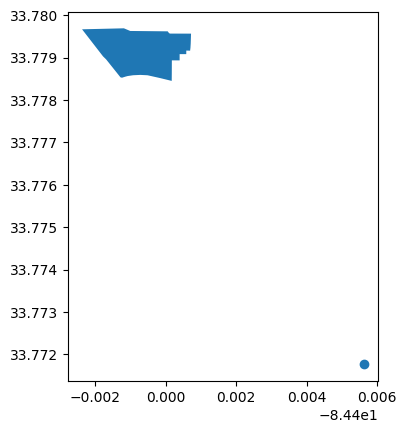

In [9]:
buildings_gdf = ox.geometries_from_place(PLACE, tags={'building': True})
#buildings_gdf.plot()

parks_gdf.plot()

/var/folders/97/v5lvp9nx3ks37kdf8m7qgyl80000gp/T/ipykernel_2409/2751584410.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  natural_scrub_gdf = ox.geometries_from_place(PLACE, tags={'natural': True})


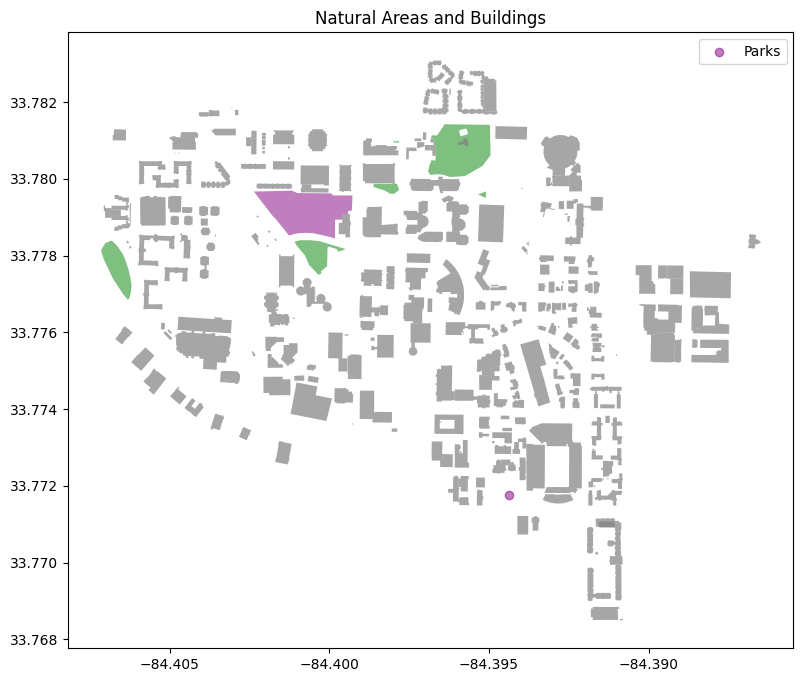

In [19]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))


# https://wiki.openstreetmap.org/wiki/Map_features

# Plot both layers on the same axis
natural_scrub_gdf = ox.geometries_from_place(PLACE, tags={'natural': True})
natural_scrub_gdf.plot(ax=ax, color='green', alpha=0.5, label='Natural Areas')
buildings_gdf.plot(ax=ax, color='gray', alpha=0.7, label='Buildings')
parks_gdf.plot(ax=ax, color='purple', alpha=0.5, label='Parks')


# Add a legend
plt.legend()

# Add a title
plt.title('Natural Areas and Buildings')

# Show the plot
plt.show()